In [1]:
%pip install moexalgo

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import holidays
import pandas as pd
import numpy as np
import moexalgo
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from tqdm import tqdm

# IMOEX

In [21]:
imoex = moexalgo.Ticker('IMOEX')
df = pd.DataFrame()

date = datetime.strptime('2019-04-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-04-02', '%Y-%m-%d')
while date < end_date:
    date_end = min(date + timedelta(days=30 * 5), end_date)
    df_per = imoex.candles(date=date.date(), till_date=date_end.date(), period='10m')
    df = pd.concat([df, df_per], ignore_index=True)
    date = date_end
    print(date.date(), len(df))
df.head()

2019-08-29 5724
2020-01-26 11232
2020-06-24 16737
2020-11-21 22405
2021-04-20 27967
2021-09-17 33799
2022-02-14 39512
2022-07-14 43959
2022-12-11 49683
2023-05-10 55245
2023-10-07 61023
2024-03-05 66630
2024-04-02 67710


,open,close,high,low,value,volume,begin,end
0,2498.73,2503.48,2505.00,2498.73,1.952391e+09,0.0,2019-04-01 10:00:00,2019-04-01 10:09:59
1,2503.49,2508.86,2509.38,2503.05,1.145601e+09,0.0,2019-04-01 10:10:00,2019-04-01 10:19:59
2,2508.69,2508.33,2508.76,2507.16,7.829220e+08,0.0,2019-04-01 10:20:00,2019-04-01 10:29:59
3,2508.31,2506.96,2508.72,2505.92,5.342177e+08,0.0,2019-04-01 10:30:00,2019-04-01 10:39:59
4,2506.95,2507.12,2509.30,2506.33,7.074240e+08,0.0,2019-04-01 10:40:00,2019-04-01 10:49:59


In [22]:
df.tail()

,open,close,high,low,value,volume,begin,end
67705,3370.64,3372.51,3372.57,3370.56,1.202155e+09,0.0,2024-04-02 18:10:00,2024-04-02 18:19:59
67706,3372.52,3374.01,3374.41,3371.92,1.962069e+09,0.0,2024-04-02 18:20:00,2024-04-02 18:29:59
67707,3374.04,3374.91,3375.69,3373.41,2.836125e+09,0.0,2024-04-02 18:30:00,2024-04-02 18:39:59
67708,3374.91,3374.91,3374.91,3374.91,0.000000e+00,0.0,2024-04-02 18:40:00,2024-04-02 18:49:59
67709,3371.29,3371.29,3371.29,3371.29,1.007402e+09,0.0,2024-04-02 18:50:00,2024-04-02 18:54:06


<Axes: >

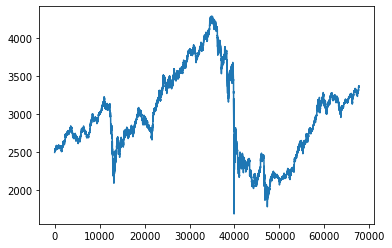

In [23]:
df['open'].plot()

In [26]:
# compute statistics
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

df = df.rename(columns={'begin': 'date'})

grouped = df.groupby(df['date'].dt.date)

stats_df = pd.DataFrame()

# compute statistics for each group
# open
stats_df['open'] = grouped['open'].first()
# close 
stats_df['close'] = grouped['open'].last()
# Average closing price
stats_df['average'] = grouped['open'].mean()   

# Median
stats_df['median'] = grouped['open'].median()  
# Min
stats_df['min'] = grouped['open'].min() 
# Max
stats_df['max'] = grouped['open'].max()  
# Standard deviation
stats_df['standard_deviation'] = grouped['open'].std()
# Average min max price range 
stats_df['price_range_average'] = grouped.apply(lambda x: (x['high'] - x['low']).mean())    

# Exponential smoothing
smoothing_parameters = {'trend': 'add'}

def double_exponential_smoothing(data):
    double_exp_smooth_model = sm.tsa.ExponentialSmoothing(data, **smoothing_parameters)
    double_exp_smooth_fit = double_exp_smooth_model.fit()
    smoothed_values_double_exp = double_exp_smooth_fit.fittedvalues
    return smoothed_values_double_exp

for group_name, group_data in tqdm(grouped):
    exp_smooth_model = sm.tsa.SimpleExpSmoothing(group_data['open'])
    exp_smooth_fit = exp_smooth_model.fit()
    smoothed_values_exp = exp_smooth_fit.fittedvalues

    # Double exponential smoothing
    smoothed_values_double_exp = double_exponential_smoothing(group_data['open'])

    # Update stats_df with exponential smoothing result
    stats_df.loc[group_name, 'exponential_smoothing'] = smoothed_values_exp.iloc[-1]

    # Update stats_df with double exponential smoothing result
    stats_df.loc[group_name, 'double_exponential_smoothing'] = smoothed_values_double_exp.iloc[-1]

stats_df.head()

100%|██████████| 1249/1249 [00:15<00:00, 81.03it/s]


,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing
date,,,,,,,,,,
2019-04-01,2498.73,2521.25,2516.402407,2516.69,2498.73,2525.40,6.359946,2.331667,2525.080000,2525.504905
2019-04-02,2523.03,2527.77,2525.199259,2525.67,2514.99,2532.04,4.036502,2.428148,2528.949623,2529.033643
2019-04-03,2530.90,2532.32,2541.529074,2541.25,2530.90,2548.24,3.571298,2.788148,2536.214933,2536.204625
2019-04-04,2530.56,2535.50,2530.664444,2530.67,2524.94,2537.87,3.401977,2.313333,2535.382692,2535.509853
2019-04-05,2535.02,2540.99,2540.099074,2539.21,2535.02,2547.83,3.327502,2.089444,2542.890000,2543.007231


In [27]:
for col in stats_df.columns:
    if not ('open' in col or 'close' in col):
        stats_df[col + '_window2'] = [0] * len(stats_df)
        stats_df[col + '_window3'] = [0] * len(stats_df)
        stats_df[col + '_window5'] = [0] * len(stats_df)
        stats_df[col + '_window7'] = [0] * len(stats_df)

In [28]:
dates = list(stats_df.index)
for i in tqdm(range(7, len(dates))):
    for k in (2, 3, 5, 7):
        cur_dates = dates[i - k:i]
        data = df[df['date'].dt.date.isin(cur_dates)]

        stats_df['average_window' + str(k)].iloc[i] = data['open'].mean()   
        stats_df['median_window' + str(k)].iloc[i] = data['open'].median()  
        stats_df['min_window' + str(k)].iloc[i] = data['open'].min() 
        stats_df['max_window' + str(k)].iloc[i] = data['open'].max()  
        stats_df['standard_deviation_window' + str(k)].iloc[i] = data['open'].std()
        stats_df['price_range_average_window' + str(k)].iloc[i] = (data['high'] - data['low']).mean()
        
        exp_smooth_model = sm.tsa.SimpleExpSmoothing(data['open'])
        exp_smooth_fit = exp_smooth_model.fit()
        smoothed_values_exp = exp_smooth_fit.fittedvalues

        smoothed_values_double_exp = double_exponential_smoothing(data['open'])
        stats_df['exponential_smoothing_window' + str(k)].iloc[i] = smoothed_values_exp.iloc[-1]
        stats_df['double_exponential_smoothing_window' + str(k)].iloc[i] = smoothed_values_double_exp.iloc[-1]
    

100%|██████████| 1242/1242 [02:19<00:00,  8.93it/s]


In [29]:
stats_df.tail()

,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing,average_window2,average_window3,average_window5,average_window7,median_window2,median_window3,median_window5,median_window7,min_window2,min_window3,min_window5,min_window7,max_window2,max_window3,max_window5,max_window7,standard_deviation_window2,standard_deviation_window3,standard_deviation_window5,standard_deviation_window7,price_range_average_window2,price_range_average_window3,price_range_average_window5,price_range_average_window7,exponential_smoothing_window2,exponential_smoothing_window3,exponential_smoothing_window5,exponential_smoothing_window7,double_exponential_smoothing_window2,double_exponential_smoothing_window3,double_exponential_smoothing_window5,double_exponential_smoothing_window7
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-27,3291.70,3304.09,3288.378333,3287.015,3280.70,3304.09,5.788390,2.219444,3296.430000,3296.887029,3269.331481,3273.288395,3274.734593,3280.687513,3277.655,3278.530,3277.670,3282.655,3235.38,3235.38,3235.38,3235.38,3289.65,3297.12,3297.12,3306.47,16.922440,16.026099,13.524558,15.702448,3.115278,3.300000,3.306074,3.242937,3284.250000,3284.448823,3284.394789,3284.370538,3284.592174,3284.414448,3284.463630,3284.311933
2024-03-28,3308.26,3312.77,3307.096667,3306.680,3303.03,3312.77,1.933474,2.207778,3309.383328,3309.500594,3285.974259,3275.680432,3277.674259,3279.065794,3284.725,3282.555,3281.955,3281.725,3276.16,3235.38,3235.38,3235.38,3304.09,3304.09,3304.09,3304.09,5.221675,16.806802,14.524033,14.287123,2.482315,2.816667,3.109593,3.216905,3296.508313,3296.430000,3296.547564,3296.525896,3296.687583,3296.758256,3296.617249,3296.553102
2024-03-29,3313.17,3332.53,3317.017037,3317.170,3305.60,3332.53,6.662285,2.102963,3329.402098,3329.628459,3297.737500,3293.015062,3283.068037,3281.306852,3303.130,3288.705,3284.640,3282.670,3280.70,3276.16,3235.38,3235.38,3312.77,3312.77,3312.77,3312.77,10.337335,10.913892,18.445077,16.404756,2.213611,2.390802,2.865444,2.993942,3308.420868,3308.635983,3308.797006,3308.701712,3308.667354,3308.840999,3308.895381,3308.835309
2024-04-01,3343.66,3363.29,3359.709630,3360.395,3343.66,3367.19,4.110455,2.490000,3363.240000,3363.141788,3312.056852,3304.164012,3290.231000,3287.497857,3308.985,3306.645,3288.705,3285.755,3303.03,3280.70,3235.38,3235.38,3332.53,3332.53,3332.53,3332.53,6.976437,12.990143,22.520656,20.155105,2.155370,2.176728,2.552148,2.836958,3328.990317,3329.399156,3329.443536,3329.253002,3329.317296,3329.620254,3329.713946,3329.382966
2024-04-02,3369.32,3371.29,3364.823519,3364.665,3357.98,3374.91,3.560969,2.295185,3374.644714,3374.734984,3338.363333,3327.941111,3311.154370,3298.866693,3338.095,3317.170,3306.645,3292.080,3305.60,3303.03,3276.16,3235.38,3367.19,3367.19,3367.19,3367.19,22.142211,23.359409,27.598817,31.742029,2.296481,2.266914,2.353074,2.702884,3363.240000,3363.240000,3363.240000,3363.229396,3363.101705,3363.581755,3363.526598,3363.431767


In [30]:
stats_df = stats_df[7:]

In [36]:
# add shifts
# fea = stats_df.columns
# for col in fea:
#     stats_df[col + '_shift_1'] = stats_df[col].shift(1)
#     stats_df[col + '_shift_2'] = stats_df[col].shift(2)
# stats_df.head()

,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing,open_shift_1,open_shift_2,close_shift_1,close_shift_2,average_shift_1,average_shift_2,median_shift_1,median_shift_2,min_shift_1,min_shift_2,max_shift_1,max_shift_2,standard_deviation_shift_1,standard_deviation_shift_2,price_range_average_shift_1,price_range_average_shift_2,exponential_smoothing_shift_1,exponential_smoothing_shift_2,double_exponential_smoothing_shift_1,double_exponential_smoothing_shift_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-01,2498.73,2521.25,2516.907778,2517.315,2503.48,2525.47,5.977823,2.331667,2525.080000,2525.415274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,2523.03,2527.77,2525.313519,2525.960,2515.03,2532.03,4.042484,2.428148,2529.040000,2528.959627,2498.73,NaN,2521.25,NaN,2516.907778,NaN,2517.315,NaN,2503.48,NaN,2525.47,NaN,5.977823,NaN,2.331667,NaN,2525.080000,NaN,2525.415274,NaN
2019-04-03,2530.90,2532.32,2541.620556,2541.190,2532.32,2548.14,3.345347,2.788148,2536.001314,2535.788692,2523.03,2498.73,2527.77,2521.25,2525.313519,2516.907778,2525.960,2517.315,2515.03,2503.48,2532.03,2525.47,4.042484,5.977823,2.428148,2.331667,2529.040000,2525.080000,2528.959627,2525.415274
2019-04-04,2530.56,2535.50,2530.740926,2530.945,2524.95,2537.93,3.452534,2.313333,2535.323875,2535.445860,2530.90,2523.03,2532.32,2527.77,2541.620556,2525.313519,2541.190,2525.960,2532.32,2515.03,2548.14,2532.03,3.345347,4.042484,2.788148,2.428148,2536.001314,2529.040000,2535.788692,2528.959627
2019-04-05,2535.02,2540.99,2540.234444,2539.285,2535.93,2547.83,3.271110,2.089444,2542.890000,2542.935849,2530.56,2530.90,2535.50,2532.32,2530.740926,2541.620556,2530.945,2541.190,2524.95,2532.32,2537.93,2548.14,3.452534,3.345347,2.313333,2.788148,2535.323875,2536.001314,2535.445860,2535.788692


In [31]:
stats_df = stats_df.dropna()
len(stats_df)

1242

In [32]:
# 3371.29 - opening price for 02.04
stats_df['target'] = list(stats_df['open'][1:]) + [3343.66]

In [33]:
# is_friday feature
stats_df['is_friday'] = stats_df.index
stats_df['is_friday'] = stats_df['is_friday'].apply(lambda date : int(date.weekday() == 4))

# is_monday feature
stats_df['is_monday'] = stats_df.index
stats_df['is_monday'] = stats_df['is_monday'].apply(lambda date : int(date.weekday() == 0))

# is_holiday feature
ru_holidays = holidays.Russia()
stats_df['is_holiday'] = stats_df.index
stats_df['is_holiday'] = stats_df['is_holiday'].apply(lambda date : int(date in ru_holidays))

# is_start_of_month feaute
stats_df['is_start_of_month'] = stats_df.index
stats_df['is_start_of_month'] = stats_df['is_start_of_month'].apply(lambda date : int(date.day == 1))

stats_df.head()

,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing,average_window2,average_window3,average_window5,average_window7,median_window2,median_window3,median_window5,median_window7,min_window2,min_window3,min_window5,min_window7,max_window2,max_window3,max_window5,max_window7,standard_deviation_window2,standard_deviation_window3,standard_deviation_window5,standard_deviation_window7,price_range_average_window2,price_range_average_window3,price_range_average_window5,price_range_average_window7,exponential_smoothing_window2,exponential_smoothing_window3,exponential_smoothing_window5,exponential_smoothing_window7,double_exponential_smoothing_window2,double_exponential_smoothing_window3,double_exponential_smoothing_window5,double_exponential_smoothing_window7,target,is_friday,is_monday,is_holiday,is_start_of_month
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-10,2571.70,2578.58,2580.589074,2581.880,2568.20,2591.32,5.707423,2.792593,2579.358027,2579.163860,2558.655093,2552.469753,2545.920556,2538.743492,2558.085,2551.370,2542.905,2538.240,2542.61,2535.02,2524.94,2498.73,2573.48,2573.48,2573.48,2573.48,7.245471,10.748313,12.262226,15.808983,2.413056,2.305185,2.403407,2.396693,2566.950416,2567.013219,2566.982171,2567.045733,2567.221763,2567.232961,2567.134332,2567.231574,2578.37,0,0,0,0
2019-04-11,2578.37,2551.45,2567.153333,2567.385,2551.45,2585.16,8.121339,3.456481,2555.642652,2555.138077,2572.974352,2565.966420,2553.732556,2547.913016,2569.255,2565.520,2551.370,2542.905,2556.82,2542.61,2524.94,2514.99,2591.32,2591.32,2591.32,2591.32,8.853463,12.376898,18.177365,18.542792,2.717130,2.539568,2.404296,2.462540,2579.364861,2579.395097,2579.483669,2579.541000,2579.526934,2579.626288,2579.660702,2579.688944,2550.87,0,0,0,0
2019-04-12,2550.87,2559.72,2560.093704,2560.180,2550.71,2569.31,4.565859,3.074074,2555.420000,2555.586981,2573.871204,2571.034012,2561.030333,2553.906455,2575.015,2568.305,2562.730,2551.370,2551.45,2551.45,2535.02,2524.94,2591.32,2591.32,2591.32,2591.32,9.713729,9.021222,14.731261,17.144306,3.124537,2.963580,2.632926,2.609444,2555.715178,2555.728982,2555.677141,2555.695018,2555.514265,2555.647750,2555.747173,2555.754810,2564.48,1,0,0,0
2019-04-15,2564.48,2545.12,2558.738333,2562.045,2542.74,2568.64,7.268994,2.575926,2545.710000,2545.344722,2563.623519,2569.278704,2565.029259,2556.558545,2562.515,2567.780,2564.110,2558.655,2550.71,2550.71,2542.61,2524.94,2585.16,2591.32,2591.32,2591.32,7.454664,10.583753,10.729023,16.478847,3.265278,3.107716,2.829852,2.650291,2555.342385,2555.118825,2555.069926,2555.123059,2555.135621,2555.031981,2555.133965,2555.200403,2547.17,0,1,0,0
2019-04-16,2547.17,2559.84,2550.221667,2550.165,2541.31,2566.72,5.445997,3.147778,2562.066617,2562.292787,2559.416019,2561.995123,2566.386815,2560.569101,2560.700,2562.325,2565.070,2561.650,2542.74,2542.74,2542.74,2535.02,2569.31,2585.16,2591.32,2591.32,6.079630,7.724196,9.794175,12.878916,2.825000,3.035494,2.908148,2.687804,2545.710000,2545.710000,2545.708012,2545.708543,2545.656263,2545.503476,2545.635832,2545.735957,2567.95,0,0,0,0


In [34]:
stats_df.to_csv('stats_imoex_open.csv')

# News embeddings

In [35]:
news_df = pd.read_csv('bert-pca.csv').rename(columns={'pub_date': 'date'}).drop(columns=['Unnamed: 0'])
for i in range(50):
    news_df = news_df.rename(columns={str(i): f'embed_{i}'})
news_df.head()

,date,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,2019-04-02,-0.207223,0.049213,0.010351,-0.071984,0.132749,-0.031769,0.087796,-0.095348,0.045902,-0.030187,0.008588,0.045277,0.043314,0.039320,-0.129689,-0.090198,0.056459,-0.041340,0.020559,0.013445,-0.040565,-0.023050,-0.034254,0.007421,-0.046112,0.026536,-0.024516,0.061081,0.021995,-0.043198,0.004743,-0.020941,-0.013798,0.027878,0.000071,-0.001922,-0.051922,0.024498,0.031830,-0.016118,-0.013180,-0.038116,0.000415,-0.004618,0.033849,-0.005387,0.002778,-0.012165,0.001851,0.007912
1,2019-04-03,0.056366,-0.106802,0.033735,0.035069,0.284562,0.003993,0.174472,-0.008406,0.064729,0.118300,0.051167,-0.056550,-0.077510,0.006642,-0.001685,-0.009223,-0.035912,0.007601,-0.009351,0.042800,0.023328,-0.050660,-0.045043,0.007212,0.015490,0.016579,-0.006541,0.053198,-0.031112,-0.012277,0.006281,-0.023175,0.033085,0.042081,-0.041342,0.030590,-0.036745,0.033073,0.009605,-0.002414,-0.027711,-0.038180,0.025624,-0.001203,-0.003975,0.041903,-0.009630,0.012114,0.032318,0.003345
2,2019-04-04,0.071030,-0.198145,-0.016322,0.109559,0.062636,-0.127767,-0.057241,-0.114495,-0.033251,0.048287,0.028876,-0.053328,-0.040033,-0.028147,-0.074728,-0.078688,-0.013068,-0.002893,0.004745,0.020668,0.037937,-0.035796,-0.008449,0.013442,0.024041,0.022360,0.008215,-0.024887,0.016952,-0.017470,-0.028064,-0.021613,0.012015,0.051155,0.012792,0.007480,-0.013869,0.025211,0.003112,-0.026615,0.028485,-0.037367,-0.013623,0.044842,-0.030076,0.032271,0.028376,0.026891,-0.041983,-0.027032
3,2019-04-05,-0.032451,-0.057619,0.226913,-0.080498,0.186991,0.118721,0.188975,-0.149715,-0.000255,-0.032549,-0.001750,-0.004868,-0.072323,-0.002274,-0.086304,0.053516,-0.003534,-0.072710,-0.037019,-0.017950,-0.019647,-0.061074,0.004273,0.031349,0.050668,0.032401,-0.008866,0.032453,-0.038414,-0.009400,-0.050097,-0.044268,0.000605,-0.013414,0.035128,-0.008525,-0.018477,0.022194,0.035211,0.018021,-0.019640,0.016340,-0.044090,-0.048375,0.016054,0.046940,-0.053203,0.022496,-0.025587,0.024941
4,2019-04-06,0.067771,-0.150039,-0.069920,-0.088551,0.078365,-0.085410,0.167671,-0.242539,-0.019562,0.036444,0.006927,-0.090330,-0.031144,-0.113010,0.007878,0.024422,-0.028931,0.016823,-0.048037,0.035193,-0.028149,-0.037646,0.022225,0.069577,0.000895,0.021459,-0.042836,0.070979,0.009659,0.013891,-0.016938,-0.004284,0.039449,-0.022190,-0.003520,-0.005665,-0.035173,0.028038,0.044939,-0.037963,0.015449,0.009760,-0.021972,0.002561,0.014349,-0.009243,0.032284,0.049740,0.033341,0.000582


In [36]:
news_df.tail()

,date,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
1755,2024-04-01,0.396872,0.314144,0.006812,-0.085198,0.212492,-0.037562,-0.038667,-0.119705,0.002358,-0.011568,-0.006212,0.023033,-0.124594,0.113460,0.033222,-0.048374,-0.058311,-0.047284,0.086754,0.110143,-0.045930,0.017569,0.069691,-0.037939,-0.033908,0.041598,0.023898,-0.075094,-0.022916,0.066137,-0.015142,0.004946,0.085554,-0.038303,0.021583,0.087166,0.027104,-0.049816,-0.015613,-0.017960,0.055579,0.030509,0.066787,0.001849,-0.069827,0.006435,0.039037,0.028135,-0.047001,-0.008332
1756,2024-04-02,0.302750,0.110310,0.114665,0.069655,0.082309,0.153423,-0.228377,0.061176,-0.011718,-0.009156,0.051737,0.075097,0.143165,-0.029944,0.121723,0.084877,0.009199,0.012754,-0.049095,0.043053,0.002128,-0.023285,-0.022430,-0.013932,-0.019643,0.004371,0.028947,0.009574,-0.030808,-0.019744,0.002772,-0.051600,-0.014018,0.030181,0.039454,0.031833,0.000943,-0.011454,0.011438,-0.033858,-0.005299,-0.013175,-0.002805,-0.020426,0.060215,0.008811,-0.000545,0.022525,0.013587,-0.026243
1757,2024-04-03,0.165696,0.018308,0.247980,0.085417,0.102076,0.005777,-0.164476,0.038848,0.010343,-0.033215,0.033242,0.077031,0.105392,0.000391,0.047711,0.049667,0.011532,-0.023060,-0.031287,0.008237,-0.012203,-0.008237,-0.047370,-0.061849,-0.015104,-0.004861,-0.007883,-0.006020,-0.014550,0.004966,-0.039340,-0.034575,0.049572,0.022503,0.012952,0.021931,0.021397,0.004193,0.002737,-0.026661,0.005372,0.021104,-0.048686,-0.011714,0.025758,-0.007086,0.028532,0.015576,0.010079,-0.001526
1758,2024-04-04,0.018199,-0.045017,0.086670,0.131755,0.068901,0.135357,-0.225042,-0.067355,0.035563,-0.054055,0.043595,0.024301,0.107930,0.004890,0.042728,0.118415,-0.015596,0.015694,-0.023635,-0.019606,0.005834,-0.007541,-0.015987,-0.017250,0.006067,-0.026564,0.003127,0.015837,-0.051847,-0.003720,-0.016420,-0.024038,0.029168,-0.010840,0.052356,0.039496,0.024193,-0.005388,0.023438,-0.017577,0.003838,0.003698,-0.027880,0.002705,0.033149,0.001372,0.000880,-0.006642,0.013118,-0.008836
1759,2024-04-04,0.253458,-0.084048,0.193755,0.122339,0.048211,0.133303,-0.207608,0.078786,0.021174,-0.056237,0.062906,0.064799,0.126127,-0.007268,0.012220,0.090081,0.012080,0.004918,-0.033990,0.007360,0.003131,0.016639,-0.042737,-0.047741,0.004233,-0.067039,-0.014455,-0.011080,-0.034809,0.003919,0.001435,-0.023211,0.026581,-0.013705,0.020791,0.007560,0.030568,0.008735,0.039640,-0.014246,-0.019692,0.024716,-0.008361,-0.031629,0.048964,0.010823,-0.000489,-0.017718,0.009095,-0.006435


In [37]:
stocks_df = pd.read_csv('stats_imoex_open.csv')

In [38]:
df = pd.merge(stocks_df, news_df, on='date', how='inner')
df.head()

,date,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing,average_window2,average_window3,average_window5,average_window7,median_window2,median_window3,median_window5,median_window7,min_window2,min_window3,min_window5,min_window7,max_window2,max_window3,max_window5,max_window7,standard_deviation_window2,standard_deviation_window3,standard_deviation_window5,standard_deviation_window7,price_range_average_window2,price_range_average_window3,price_range_average_window5,price_range_average_window7,exponential_smoothing_window2,exponential_smoothing_window3,exponential_smoothing_window5,exponential_smoothing_window7,double_exponential_smoothing_window2,...,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,2019-04-10,2571.70,2578.58,2580.589074,2581.880,2568.20,2591.32,5.707423,2.792593,2579.358027,2579.163860,2558.655093,2552.469753,2545.920556,2538.743492,2558.085,2551.370,2542.905,2538.240,2542.61,2535.02,2524.94,2498.73,2573.48,2573.48,2573.48,2573.48,7.245471,10.748313,12.262226,15.808983,2.413056,2.305185,2.403407,2.396693,2566.950416,2567.013219,2566.982171,2567.045733,2567.221763,...,-0.009145,-0.017099,0.053937,-0.021382,0.002379,-0.044615,0.030344,-0.031999,-0.026558,0.031940,0.006469,-0.097522,-0.025495,0.013765,0.017531,0.049443,-0.037943,0.018642,-0.015990,0.008725,0.025315,-0.047518,-0.022412,0.008870,0.057152,0.001072,0.066918,0.021410,0.016063,0.000087,0.001680,-0.008341,0.025299,-0.047279,0.011749,0.018427,-0.063661,0.020965,-0.020759,-0.022067
1,2019-04-11,2578.37,2551.45,2567.153333,2567.385,2551.45,2585.16,8.121339,3.456481,2555.642652,2555.138077,2572.974352,2565.966420,2553.732556,2547.913016,2569.255,2565.520,2551.370,2542.905,2556.82,2542.61,2524.94,2514.99,2591.32,2591.32,2591.32,2591.32,8.853463,12.376898,18.177365,18.542792,2.717130,2.539568,2.404296,2.462540,2579.364861,2579.395097,2579.483669,2579.541000,2579.526934,...,0.064316,-0.068434,-0.016868,-0.050578,0.000476,-0.064271,0.011584,-0.032192,-0.014640,0.018673,-0.007736,-0.063405,-0.048910,-0.067918,0.054933,0.047476,0.004324,-0.025706,0.002638,-0.019209,0.012108,0.031421,0.026823,0.003390,-0.055900,0.022910,0.024787,0.043919,0.026515,-0.026181,-0.016479,0.033675,-0.005803,-0.016824,0.037643,0.017715,0.018166,-0.038453,-0.010503,-0.083353
2,2019-04-12,2550.87,2559.72,2560.093704,2560.180,2550.71,2569.31,4.565859,3.074074,2555.420000,2555.586981,2573.871204,2571.034012,2561.030333,2553.906455,2575.015,2568.305,2562.730,2551.370,2551.45,2551.45,2535.02,2524.94,2591.32,2591.32,2591.32,2591.32,9.713729,9.021222,14.731261,17.144306,3.124537,2.963580,2.632926,2.609444,2555.715178,2555.728982,2555.677141,2555.695018,2555.514265,...,-0.029014,-0.081533,0.009149,-0.069129,0.045426,-0.047195,0.028309,-0.049277,-0.081661,-0.056326,0.027823,-0.027317,-0.017471,-0.018764,0.053599,0.023301,-0.025196,0.014830,-0.023544,0.016470,0.027150,-0.012344,0.003003,-0.016627,0.009584,-0.035848,-0.036979,0.019561,0.020065,-0.047644,0.002036,0.032801,0.011396,-0.036418,0.009460,-0.029904,-0.043184,0.045716,0.003264,-0.024021
3,2019-04-15,2564.48,2545.12,2558.738333,2562.045,2542.74,2568.64,7.268994,2.575926,2545.710000,2545.344722,2563.623519,2569.278704,2565.029259,2556.558545,2562.515,2567.780,2564.110,2558.655,2550.71,2550.71,2542.61,2524.94,2585.16,2591.32,2591.32,2591.32,7.454664,10.583753,10.729023,16.478847,3.265278,3.107716,2.829852,2.650291,2555.342385,2555.118825,2555.069926,2555.123059,2555.135621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [41]:
len(df), len(df.dropna()), len(stocks_df), len(news_df), len(news_df.dropna())

(1211, 1211, 1242, 1760, 1760)

In [40]:
df.to_csv('dataset_v4_open.csv', index=False)